## Alessandro Bianchetti

## Exercise 7

Consider a bivariate Gaussian distribution N($\mu$,$\Sigma$), where $\mu$ = (4, 2),
$\Sigma_{11}$ = 1.44, $\Sigma_{22}$ = 0.81, $\Sigma_{12}$ = $\Sigma_{12}$ = −0.702. Assume that such distribution
describes the posterior of two parameters $X_1$ and $X_2$. Plot contours
of this distribution and tell what are the boundaries of the 95\% credibile
interval for each parameter, after marginalizing over the other. Tell how
these boundaries change if, instead of marginalizing, we fix either parameter
to a known value. Now, re-obtain the same boundaries via Monte
Carlo sampling of the posterior, in three ways: a) by directly drawing values
of ($X_1$,$X_2$), by mean of a a Cholesky decomposition of the covariance
(check in the literature how to do this); b) Via Metropolis-Hastings sampling
of the posterior, c) Via Gibbs sampling of the posterior. In all cases,
do not rely on pre-made code, but write your own (i.e., you can surely
use libraries to generate known distributions, do Cholesky decomposition,
and so on, but you should not use a pre-made library with a command like
”Gibbs-sampling”). In all cases, provide final contour plots, and marginalized
posteriors. In the MCMC analysis, produce also trace plots to test
for convergence of the chains. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from numpy.random import random, seed
from scipy.stats import multivariate_normal as mvn
import scipy.integrate as integrate

%matplotlib notebook

ImportError: DLL load failed: %1 non è un'applicazione di Win32 valida.

## Part 0: plotting the distribution
In order to make notation  easier, inside code cells the parameters $X_1$ and $X_2$ become X and Y. 

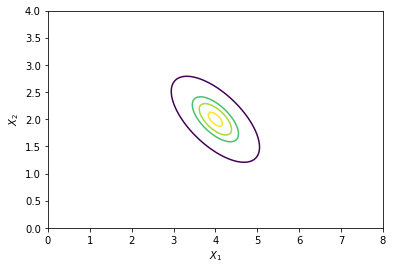

In [2]:
D = int(2)
x = np.random.rand(D)
mu = np.array([4,2],float)
cov = np.array([[1.44,-0.702],[-0.702,0.81]])
det = cov[0,0]*cov[1,1]-cov[0,1]**2
prec = np.linalg.inv(cov)


x, y = np.meshgrid(np.linspace(0,8,100),np.linspace(0,4,100))
xy = np.column_stack([x.flat, y.flat])
z = mvn.pdf(xy, mu, cov).reshape(x.shape)

# arbitrary contour levels, of course here the numbers are just symbolic and they have nothing to do with credibility intervals
max = 0.19371
contour_level = [0.68*max,0.9*max,0.95*max,0.99*max]

fig = plt.contour(x, y, z, levels = contour_level)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

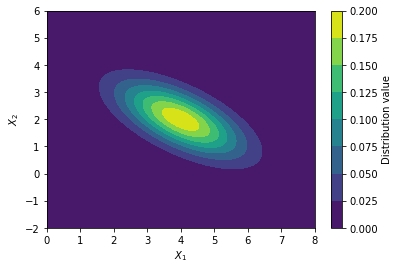

In [3]:
N = int(1e3)
xvec = np.linspace(0,8,N)
yvec = np.linspace(-2,6,N)
x, y = np.meshgrid(xvec,yvec)
xy = np.dstack((x, y))
rv = mvn(mu, cov)
z = rv.pdf(xy)

cs = plt.contourf(x, y, z, cmap="viridis")
cbar = plt.colorbar(cs, orientation="vertical", label="Distribution value")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.tight_layout
plt.show()

In [4]:
#useful functions

# a one-dimensional gaussian
def gaussian(x,any_mean,any_sigma):
    c = 1./np.sqrt(any_sigma)*1/(2*np.pi)**0.5*np.e**(-0.5*(x-any_mean)**2/any_sigma)
    return c


# a function to compute credibility intervals exploiting scipy.quad
alpha = 0.95
eps=1e-4

def find_95(any_mean,any_sigma):
    interval_y = [any_mean-eps, any_mean+eps]
    I=[0,0]

    while(I[0]<alpha): 
        I = integrate.quad(gaussian, interval_y[0], interval_y[1], epsrel=1.e-5, args=(any_mean,any_sigma))
        interval_y[0] -= eps
        interval_y[1] += eps
        
    return interval_y

## Part 1: marginalization
We marginalize the original BVN over X to get the posterior for Y. The marginalization process over a MVN is known to yield another MVN with the untouched mean component of the non-marginalised variables, whilst affecting the variance. In our case, we end up with a univariate normal distribution with mean $\mu_y$ and variance $C_{yy}$, ie by the corresponding submatrix of the covariance matrix, in our case it is just a scalar. If we label $C^{-1}=V$ as the precision matrix, we can write the marginalised posterior as
$$
UVN(y) = \mathcal{N}(y|\mu_y, (V_{yy}-V_{xy}V_{xx}^{-1}V_{xy})^{-1}) = \mathcal{N}(y|\mu_y, C_{yy})
$$
We can perform the integration in two different ways. First, we use scipy.quad to loop over that integral until we find the correct interval. 


In [5]:
N = int(1000)
mean = mu[1]
sigma = cov[1,1]

cred_interval_marg_y = find_95(mean,sigma)
print("X2 credibility interval:    ", cred_interval_marg_y)
bar = cred_interval_marg_y[1]-mean
print("X2 = ", "{:.2f}".format(mean), "+-", "{:.2f}".format(bar))

X2 credibility interval:     [0.2359000000001943, 3.764100000003723]
X2 =  2.00 +- 1.76


We now marginalize over Y, thus getting the posterior for X and extracting the credibility interval in X. This time the marginalized posterior is
$$
UVN(x) = \mathcal{N}(x|\mu_x,C_{xx})
$$

In [6]:
mean = mu[0]
sigma = cov[0,0]

cred_interval_marg_x = find_95(mean,sigma)
print("X1 credibility interval:    ", cred_interval_marg_x)
bar = cred_interval_marg_x[1]-mean
print("X1 = ", "{:.2f}".format(mean), "+-", "{:.2f}".format(bar))

X1 credibility interval:     [1.6478999999958184, 6.352099999994518]
X1 =  4.00 +- 2.35


In this simple 2D case, we quickly obtained the marginalized posterior by working with a scalar variance. But as dimensions grow, finding the analytical expression for the new covariance can become costly. An alternative path for the marginalization integral could be graphical: projecting the above 2D histogram on either axis is the exact way to visualize the marginalization process. After projection, we get a univariate Gaussian, for which we can calculate the credibility interval. We do this for $X_2$ (or y), then for $X_1$ (or x).

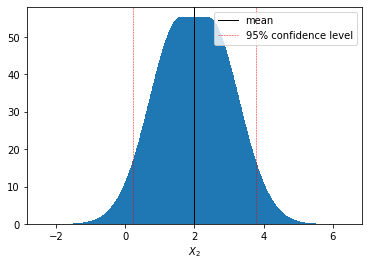

Credibility interval:    [ 0.23423423423423406 , 3.7737737737737733 ]
X2 =  2.00 +- 1.77


In [12]:
marg_post_y = np.zeros(N, float)
for i in range(N):
    for j in range(N):
        marg_post_y[i] += z[i,j]

mean = 0.
for i in range(int(len(marg_post_y))):
    mean += yvec[i]*marg_post_y[i]
mean /= sum(marg_post_y)


plt.bar(yvec,marg_post_y)
plt.xlabel("$X_2$")

bin_width = (yvec[-1]-yvec[0])/N
I = sum(marg_post_y)*bin_width
#print(I)   we have to perform the total integral because it is unnormalised
alpha = 0.95*I

ind = int(N/2)

ind1 = ind-1
ind2 = ind+1
I0=0
while(I0<alpha): 
    I0=0
    for j in range(ind1,ind2):
        I0 += marg_post_y[j]*bin_width
    ind1 -=1
    ind2 +=1

plt.axvline(mean,linewidth=1.0,color='k', label="mean")
plt.axvline(yvec[ind1],linewidth=0.5,color='red', linestyle='--', label="95% confidence level")
plt.axvline(yvec[ind2],linewidth=0.5,color='red', linestyle='--')
plt.legend()
plt.show()   

print("Credibility interval:    [", yvec[ind1],",", yvec[ind2],"]")
bar = yvec[ind2]-mean
print("X2 = ", "{:.2f}".format(mean), "+-", "{:.2f}".format(bar))
    

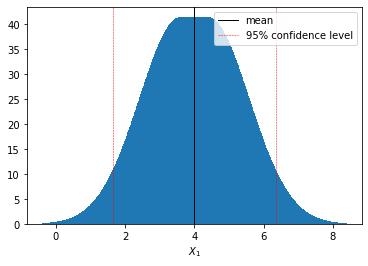

Credibility interval:    [ 1.6496496496496496 , 6.358358358358358 ]
X1 =  4.00 +- 2.36


In [13]:
marg_post_x = np.zeros(N, float)
for i in range(N):
    for j in range(N):
        marg_post_x[i] += z[j,i]

plt.bar(xvec,marg_post_x)
plt.xlabel("$X_1$")

mean = 0.
for i in range(int(len(marg_post_x))):
    mean += xvec[i]*marg_post_x[i]
mean /= sum(marg_post_x)

bin_width = (xvec[-1]-xvec[0])/N
I = sum(marg_post_x)*bin_width
alpha = 0.95*I 

ind = int(N/2)

ind1 = ind-1
ind2 = ind+1
I0=0
while(I0<alpha): 
    I0=0
    for j in range(ind1,ind2):
        I0 += marg_post_x[j]*bin_width
    ind1 -=1
    ind2 +=1

plt.axvline(mean,linewidth=1.0,color='k', label="mean")
plt.axvline(xvec[ind1],linewidth=0.5,color='red', linestyle='--', label="95% confidence level")
plt.axvline(xvec[ind2],linewidth=0.5,color='red', linestyle='--')
plt.legend()
plt.show()   


print("Credibility interval:    [", xvec[ind1],",", xvec[ind2],"]")
bar = xvec[ind2]-mean
print("X1 = ", "{:.2f}".format(mean), "+-", "{:.2f}".format(bar))
        

We're happy to notice that both methods produce the same credibility intervals on the two parameters.

In [15]:
# if I don't re-run this cell with the function before going on with conditioning, sometimes I have issues, so better to run it again now

alpha = 0.95
eps=1e-4

def find_95(any_mean,any_sigma):
    interval_y = [any_mean-eps, any_mean+eps]
    I=[0,0]

    while(I[0]<alpha): 
        I = integrate.quad(gaussian, interval_y[0], interval_y[1], epsrel=1.e-5, args=(any_mean,any_sigma))
        interval_y[0] -= eps
        interval_y[1] += eps
        #print(interval_y)
        
    return interval_y

## Part 2: conditioning

Next step is computing the credibility interval after fixing either parameter, instead of marginalizing over it. We take the BVN and just fix both parameters, one at a time, to 3 (just a random choice). Conditioning produces another MVN with unchanged covariance, but new mean. A conditioned BVN (fixed y) becomes the following UVN(x)
$$
UVN(x) = \mathcal{N}(x|\mu_x-V_{xx}^{-1}V_{xy}(y-\mu_y),V_{xx}^{-1})
$$

In [21]:
sigma_cond_x = 1./np.sqrt(prec[0,0])
#y_sample = np.random.normal(loc=mu[1], scale=cov[1,1],size=20)
#y = sum(y_sample)/len(y_sample)
y = 3.
mean_cond_x = mu[0]-prec[0,1]/prec[0,0]*(y-mu[1])      #fixing y to its mean cancels the extra term. Watch out, fixing the parameter influences the obtained interval
print("Conditioned mean:    ", mean_cond_x)


cred_interval_cond_x = find_95(mean_cond_x,sigma_cond_x)
print("Credibility interval:    ", cred_interval_cond_x)
bar = cred_interval_cond_x[1]-mean_cond_x
print("X1 = ", "{:.2f}".format(mean_cond_x), "+-", "{:.2f}".format(bar))

Conditioned mean:     3.1333333333333333
Credibility interval:     [1.261533333331023, 5.00513333333282]
X1 =  3.13 +- 1.87


In [22]:
sigma_cond_y = 1./np.sqrt(prec[1,1])
#x_sample = np.random.normal(loc=mu[0], scale=cov[0,0],size=20)
#x = sum(x_sample)/len(x_sample)
x=3.
mean_cond_y = mu[1]-prec[0,1]/prec[1,1]*(x-mu[0])      #fixing y to its mean cancels the extra term. Watch out, fixing the parameter influences the obtained interval
print("Conditioned mean:    ", mean_cond_y)

cred_interval_cond_y = find_95(mean_cond_y,sigma_cond_y)
print("Credibility interval:    ", cred_interval_cond_y)
bar = cred_interval_cond_y[1]-mean_cond_y
print("X2 = ", "{:.2f}".format(mean_cond_y), "+-", "{:.2f}".format(bar))

Conditioned mean:     2.4875
Credibility interval:     [0.8663999999990961, 4.108600000002938]
X2 =  2.49 +- 1.62


The credibility intervals are of course different with respect to the marginalization case. First of all, we're treating a physical situation in which we assume we know part of the parameters (nuisance parameters) and we're fixing them to a given value. In the above code, we fixed either x or y to a random value. However, the obtained credibility interval ddoes not depend on the fixed variable, since the width of the conditioned distribution only depend on the original covariancee. As a final result, the credibility interval are now centered on another value (the conditioned mean) and are a little narrower. This makes sense, since conditioning variables means that we improve our knowledge.

In [23]:
#define a function to integrate over a histogram
def cred_interval_hist(nfreq,bins):
    nbins = int(100)
    s = 0
    for i in range(len(nfreq)):
        s += nfreq[i] * ((bins[i] + bins[i+1]) / 2) 
    mean = s / np.sum(nfreq)
    #print("Mean value:  ", mean)

    bin_width = (bins[-1]-bins[0])/nbins
    I = bin_width * sum(nfreq[0:99])
    alpha = 0.95*I

    bin_mean = int((mean-bins[0])/bin_width)
    #print("Bin hosting the mean value:  ",bin_mean)
    bin1 = bin_mean-1
    bin2 = bin_mean+1
    I=0
    while(I<alpha): 
        I=0
        I = bin_width * sum(nfreq[bin1:bin2])
        bin1 -= 1
        bin2 += 1
        
    #print("Credibility interval:    [", bins[0]+bin1*bin_width,",",bins[0]+bin2*bin_width,"]")
    boundaries = [bins[0]+bin1*bin_width, bins[0]+bin2*bin_width]
    return mean, boundaries
    

In [24]:
# a function to perform graphical conditioning
def condition(xvec,yvec,fixed):
    conditioned=[]
    delta=0.3
    for i in range(len(yvec)):
        if(yvec[i]<=(fixed+delta) and yvec[i]>=(fixed-delta)):
            conditioned.append(xvec[i])
    return conditioned


In [25]:
# a function to plot computed confidence interval against theoretical
def plot_interval(mean,interval,mean_ref,interval_ref,label,label2):
    label=str(label)
    plt.axvline(interval_ref[0],color='k',linestyle='--')
    plt.axvline(interval_ref[1],color='k', linestyle='--',label="theoretical")
    plt.axvline(mean_ref,color='k')
    plt.axvline(mean,color='red')
    plt.axvline(interval[0],color='red', linestyle='--',label=label)
    plt.axvline(interval[1],color='red', linestyle='--')
    plt.title(str(label2))
    plt.legend()
    plt.show()

    print("Credibility interval:    [", interval[0],",",interval[1],"]")
    bar = interval[1]-mean
    print("Mean = ", "{:.2f}".format(mean), "+-", "{:.2f}".format(bar))
    

## Part 3: Cholesky decomposition

A Gaussian distribution can be generated by applying a Cholesky decomposition of the covariance. In a nutshell, Cholesky decomposition means to decompose a positive definite matrix into the product of a lower triangular matrix $L$ and its transpose, such that $\Sigma = L^T L$. After this, we can generate a set of variables following the standard Gaussian distribution $\mathcal{N}(\vec{r}|\vec{0}, \mathcal{1}_2)$. If we now define $\vec{v} = L\vec{r}+\mu$, it can be proven that $\vec{v} \in \mathcal{N}(\vec{v}|\mu, \Sigma)$.

In [26]:
L = np.linalg.cholesky(cov) # Cholesky decompositionplt.figure(figsize = (12, 6))

r = np.random.normal(loc=0.0, scale=1.0, size=(int(1e5),2))
v = []
for item in r:
    v.append(np.dot(L,item)+mu)

First we verify marginalization. We hope to find agreement with the reference theoretical values computed in Part 1.

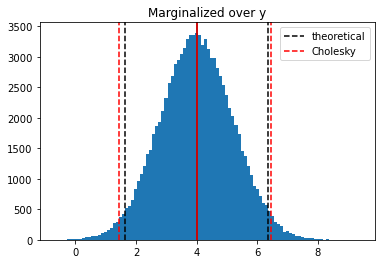

Credibility interval:    [ 1.4318218633094126 , 6.458178891805309 ]
Mean =  4.00 +- 2.46


In [27]:
X = []
Y = []
for item in v:
    X.append(item[0])
    Y.append(item[1])

nbins=int(100)
nx, binsx, _ = plt.hist(X,bins=nbins)

mean_cholesky, cred_interval_cholesky = cred_interval_hist(nx,binsx)

plot_interval(mean_cholesky,cred_interval_cholesky,mu[0],cred_interval_marg_x,"Cholesky", "Marginalized over y")

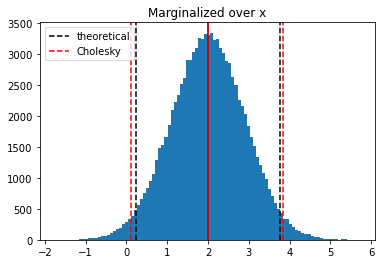

Credibility interval:    [ 0.11159688006970381 , 3.844486041699633 ]
Mean =  2.00 +- 1.84


In [28]:
ny, binsy, _ = plt.hist(Y,bins=nbins)

mean_cholesky, cred_interval_cholesky = cred_interval_hist(ny,binsy)
plot_interval(mean_cholesky,cred_interval_cholesky,mu[1],cred_interval_marg_y,"Cholesky","Marginalized over x")

Now we verify conditioning, fixing $X_2=3$ first and $X_1=3$ in the subsequent cell, exactly like we did in Part 2, which is our reference for comparison. 

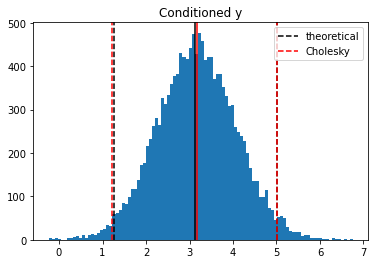

Credibility interval:    [ 1.2282384716880537 , 5.007447734399901 ]
Mean =  3.16 +- 1.84


In [29]:
condy = condition(X,Y,3.)
nx,binsx,_=plt.hist(condy,bins=nbins)

mean_cholesky, cred_interval_cholesky = cred_interval_hist(nx,binsx)
plot_interval(mean_cholesky,cred_interval_cholesky,mean_cond_x,cred_interval_cond_x,"Cholesky","Conditioned y")

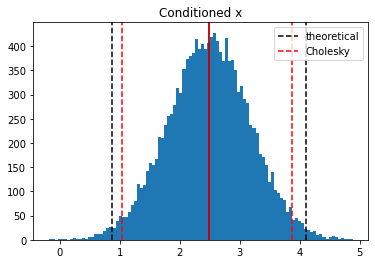

Credibility interval:    [ 1.029071997768343 , 3.872044599086612 ]
Mean =  2.49 +- 1.39


In [30]:
condx = condition(Y,X,3.)
ny,binsy,_=plt.hist(condx,bins=nbins)
mean_cholesky, cred_interval_cholesky = cred_interval_hist(ny,binsy)
plot_interval(mean_cholesky,cred_interval_cholesky,mean_cond_y,cred_interval_cond_y,"Cholesky","Conditioned x")

## Part 4: Metropoli-Hastings

Now we try out the Metropoli-Hastings method to sample the BVN. We need to define a new distribution Q, possibly symmetric like a MVN, and draw from it. An acceptance step is then considered, to check whether or not the next sample is validated. The choice of Q can be decisive in determining the efficiency of the generation. In fact, if Q has too small of a variance, an high acceptance rate is guaranteed but the steps will be very short with respect to the posterior volume in phase space. On the other hand, large variance also means inefficiency. We have to find a reasonable compromise: as you can see in the function MH just below, I chose a diagonal Gaussian as Q, with variance similar to the reference posterior.

In [31]:
#just a nice tool to display loading bars
from tqdm.notebook import tqdm

In [35]:
# these are the functions needed to perform MH

#define Q, ie proposal distribution
def gauss_2d(mean, sigmax, sigmay):
    a = np.random.normal(loc=mean[0], scale=sigmax, size=1)
    b = np.random.normal(loc=mean[1], scale=sigmay, size=1)
    return list(map(list, zip(a, b)))[0]

#define acceptance rate
def acceptance(next, curr):
    prob_next = mvn.pdf(next,mu,cov)
    prob_curr = mvn.pdf(curr,mu,cov)
    alpha = min(prob_next/prob_curr,1)
    return alpha

# a function to make decisions
def decide(p):
    k = np.random.uniform(0,1)
    if k>=p:
        return False
    else:
        return True

N=int(1e5)

#a manually-defined 2D Gaussian, since the mvn library seems kind of slow
def MVN(r):
    c = 1./(2*np.pi)*1./np.sqrt(det)*np.e**(-0.5*np.dot((r-mu), np.dot(prec, (r-mu))))
    return c

# MH algorithm
def MH(start_point):
    with tqdm(total=N) as pbar:
        r = start_point
        fin = []
        Tr = 0.
        trace = []
        while(len(fin)<N):
            fin.append(r)
            rplus = gauss_2d(r,1.5,1.0)
            Tr -= np.log(MVN(rplus))/len(fin)
            trace.append(Tr)
            alpha = acceptance(rplus,r)
            bool = decide(alpha)
            if(bool):
                r = rplus
            pbar.update(1)
    fin = np.array(fin)
    trace = np.array(trace)   
    return fin, trace 

# a function to do everything and plot results
def plot_gauss(fin,start_point):
    xtry = []
    for i in range(int(len(fin))):
        xtry.append(fin[i][0])
    ytry = []
    for i in range(int(len(fin))):
        ytry.append(fin[i][1])

    plt.hist2d(xtry,ytry,bins=(25,25))
    plt.title("Generated Gaussian profile: starting point " + str(start_point))

    

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
    nx, binsx, _  = ax1.hist(xtry,bins=100)
    ax1.set_title('Marginalized over y')
    ax1.set_xlabel("x")
    ax1.set_ylabel("counts")
    ny, binsy, _ = ax2.hist(ytry,bins=100)
    ax2.set_title('Marginalized over x')
    ax2.set_xlabel("y")

    mean_x, credx = cred_interval_hist(nx,binsx)
    mean_y, credy = cred_interval_hist(ny,binsy)
    
    ax1.axvline(mean_x,color='red')
    ax1.axvline(credx[0],color='red', linestyle='--',label="MH")
    ax1.axvline(credx[1],color='red', linestyle='--')
    ax2.axvline(mean_y,color='red')
    ax2.axvline(credy[0],color='red', linestyle='--',label="MH")
    ax2.axvline(credy[1],color='red', linestyle='--')
    ax1.axvline(cred_interval_marg_x[0],color='k',linestyle='--')
    ax1.axvline(cred_interval_marg_x[1],color='k', linestyle='--',label="theoretical")
    ax2.axvline(cred_interval_marg_y[0],color='k',linestyle="--")
    ax2.axvline(cred_interval_marg_y[1],color='k', linestyle='--',label="theoretical")

    
    plt.legend()
    plt.tight_layout
    plt.show()

    barx = mean_x-credx[0]
    bary = mean_y-credy[0]
    print("Mean X:    ",mean_x,"+-",barx)
    print("Credibility interval X:    [", credx[0],",",credx[1],"]")
    print("Mean Y:    ",mean_y,"+-",bary)
    print("Credibility interval Y:    [", credy[0],",",credy[1],"]")


    condy = condition(xtry,ytry,3.)
    nx,binsx,_=plt.hist(condy,bins=nbins)

    mean_MH, cred_interval_MH = cred_interval_hist(nx,binsx)
    plot_interval(mean_MH,cred_interval_MH,mean_cond_x,cred_interval_cond_x,"MH","Conditioned over y")

    condx = condition(ytry,xtry,3.)
    ny,binsy,_=plt.hist(condx,bins=nbins)

    mean_MH, cred_interval_MH = cred_interval_hist(ny,binsy)
    plot_interval(mean_MH,cred_interval_MH,mean_cond_y,cred_interval_cond_y,"MH","Conditioned over x")

    


  0%|          | 0/100000 [00:00<?, ?it/s]

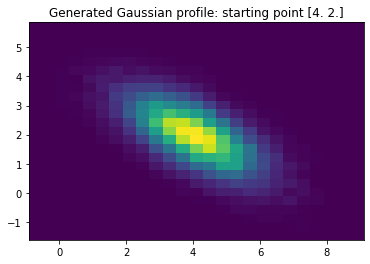

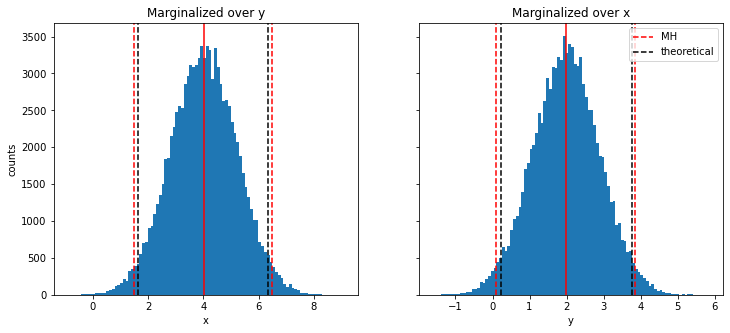

Mean X:     4.021957038594169 +- 2.531088473038592
Credibility interval X:    [ 1.4908685655555773 , 6.498704482530482 ]
Mean Y:     1.986127839228703 +- 1.8808781176605547
Credibility interval Y:    [ 0.10524972156814827 , 3.8395543368017524 ]


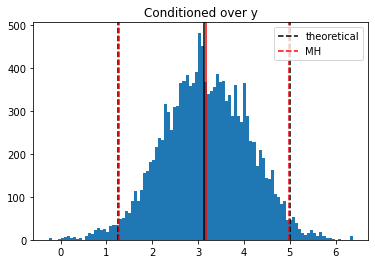

Credibility interval:    [ 1.2658783130438496 , 4.983621434330506 ]
Mean =  3.17 +- 1.81


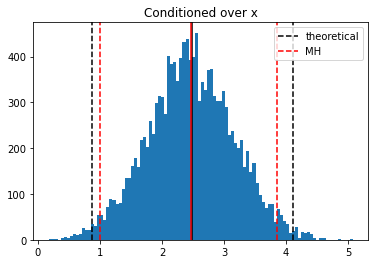

Credibility interval:    [ 1.005746144660292 , 3.850859779999401 ]
Mean =  2.47 +- 1.39


In [36]:
fin1, trace1 = MH(mu)
plot_gauss(fin1,mu)

Looking at the projected 1D plots and the 2D contour, the algorithm worked correctly. We now generated three more chains, in order to estimate variance and perfrom the Gelman-Rubin test.

  0%|          | 0/100000 [00:00<?, ?it/s]

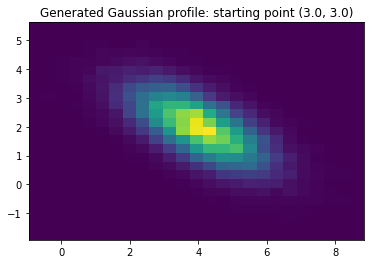

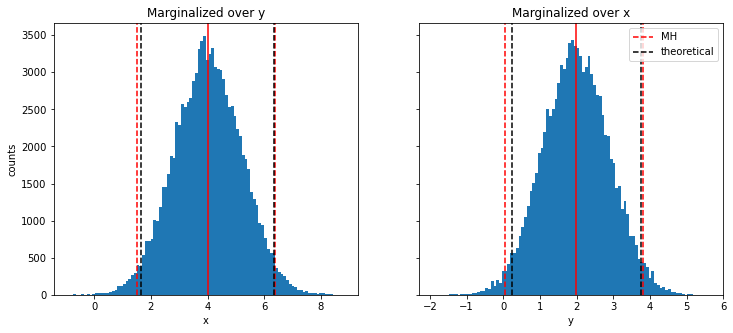

Mean X:     4.015501199646772 +- 2.51647657936031
Credibility interval X:    [ 1.4990246202864626 , 6.382583842139527 ]
Mean Y:     1.9871828300403966 +- 1.9458617733428918
Credibility interval Y:    [ 0.041321056697504854 , 3.814421348683481 ]


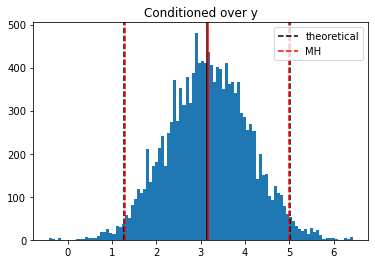

Credibility interval:    [ 1.2834491440867262 , 4.990100216766726 ]
Mean =  3.17 +- 1.82


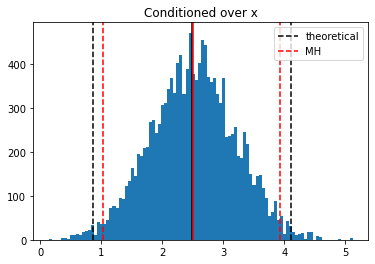

Credibility interval:    [ 1.0317671080438728 , 3.9258514934408475 ]
Mean =  2.50 +- 1.42
#############################################################################


  0%|          | 0/100000 [00:00<?, ?it/s]

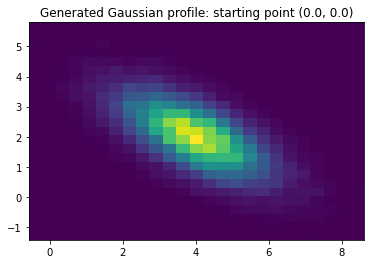

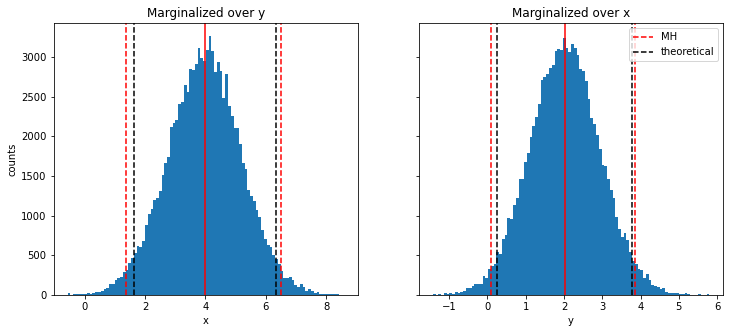

Mean X:     3.977254499543053 +- 2.6181116773986464
Credibility interval X:    [ 1.3591428221444066 , 6.493194873931109 ]
Mean Y:     2.021780279262231 +- 1.9334418107455034
Credibility interval Y:    [ 0.08833846851672744 , 3.849152664997005 ]


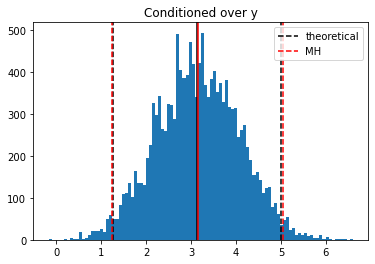

Credibility interval:    [ 1.248891831628433 , 5.042304333624807 ]
Mean =  3.15 +- 1.89


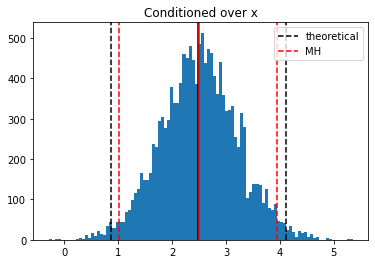

Credibility interval:    [ 1.0066012125988586 , 3.942629051124282 ]
Mean =  2.51 +- 1.43
#############################################################################


  0%|          | 0/100000 [00:00<?, ?it/s]

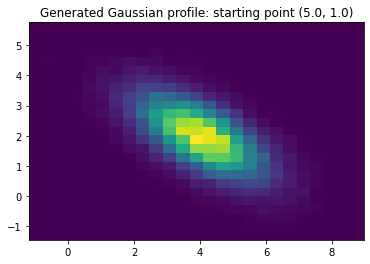

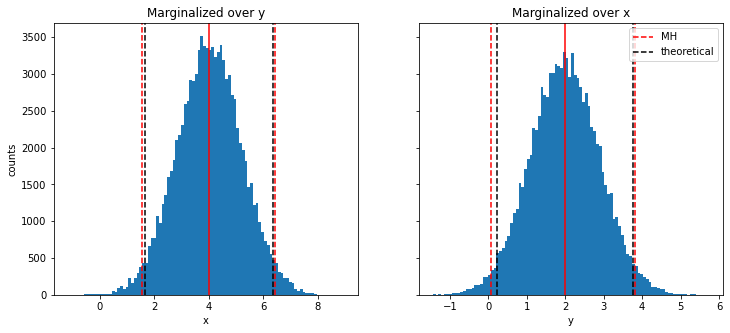

Mean X:     4.021476815813867 +- 2.465944595876385
Credibility interval X:    [ 1.5555322199374817 , 6.427115273144098 ]
Mean Y:     1.9868990065144172 +- 1.9199990586023117
Credibility interval Y:    [ 0.06689994791210552 , 3.809498380372875 ]


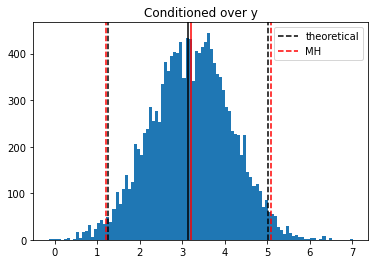

Credibility interval:    [ 1.213128467842313 , 5.079988315719495 ]
Mean =  3.20 +- 1.88


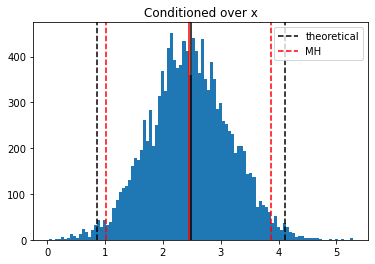

Credibility interval:    [ 1.0237840026532432 , 3.8650389200345336 ]
Mean =  2.46 +- 1.41
#############################################################################


In [37]:
r = (3.,3.)
fin2, trace2 = MH(r)
plot_gauss(fin2, r)
print("#############################################################################")

r = (0.,0.)
fin3, trace3 = MH(r)
plot_gauss(fin3, r)
print("#############################################################################")


r = (5.,1.)
fin4, trace4 = MH(r)
plot_gauss(fin4, r)
print("#############################################################################")

When running MCMC (markov Chain Montecarlo) methods, we have to take care of diagnositcs. How can we make sure the generation ran smoothly? First, we can check for convergence, i.e. making sure the chain has correctly converged to the associated stationary posterior distribution. In fact, a Markov Chain achieves a stationary probability distribution only after a while: the initial, transient phase is called burn-in phase, and we should discard these temptative points in order to guaranteee the accuracy of the sampling process. In the following cells, we plot the converging trend, cut out the burn-in phase and then re-plot.

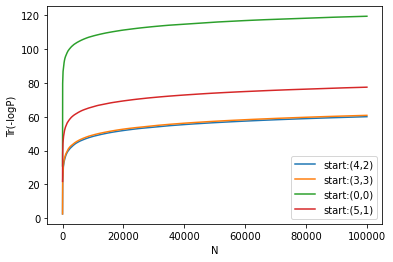

In [38]:
mvec = np.linspace(1,len(fin1),len(fin1))
plt.plot(mvec, trace1, label="start:(4,2)")
plt.plot(mvec, trace2, label="start:(3,3)")
plt.plot(mvec, trace3, label="start:(0,0)")
plt.plot(mvec, trace4, label="start:(5,1)")
plt.xlabel("N")
plt.ylabel("Tr(-logP)")
plt.legend()
plt.show()

See that all the chains are properly converging to the asymptotic stationary distribution, which we could say is conventionally reached after, say, 20000 steps. Therefore, we cut out those points to improve our estimates. However, the trace plot shows that the chains are settling on different levels. This is a sign of bad mixing, meaning that starting from different starting points we get to explore only part of the posterior volume. Cutting the burn-in data should solve this issue and show closer trace plots.

In [40]:
# after burn-in removal we have to re-compute the trace
def new_trace(fin):
    trace_new=[]
    Tr = 0.
    for i in range(int(len(fin))):
        Tr -= np.log(MVN(fin[i]))/(i+1)
        trace_new.append(Tr)
    return trace_new

In [41]:
burnin = int(0.2*len(fin1))
fin1 = fin1[burnin:]
fin2 = fin2[burnin:]
fin3 = fin3[burnin:]
fin4 = fin4[burnin:]

trace1_new=new_trace(fin1)
trace2_new=new_trace(fin2)
trace3_new=new_trace(fin3)
trace4_new=new_trace(fin4)


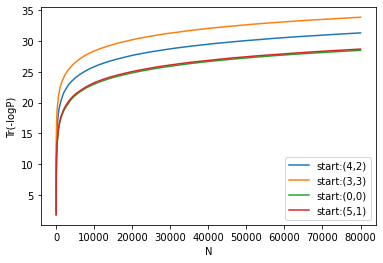

In [42]:
mvec = np.linspace(1,len(fin1),int(len(fin1)))
plt.plot(mvec, trace1_new, label="start:(4,2)")
plt.plot(mvec, trace2_new, label="start:(3,3)")
plt.plot(mvec, trace3_new, label="start:(0,0)")
plt.plot(mvec, trace4_new, label="start:(5,1)")
plt.xlabel("N")
plt.ylabel("Tr(-logP)")
plt.legend()
plt.show()

Let's perform the Gelman-Rubin test for the variance. This test is meant to check for good mixing too. Total covariance $\hat{V}=\frac{N-1}{N}W+\frac{M+1}{M}\frac{B}{N}$ is given by two different contributions: $W$ is the average variance within a chain and $B/N$ is the variance between chains. Now, the ratio $R=\hat{V}/W$ works as an estimator for mixing: the closer $R$ to 1, the better the mixing. We have already cut out the transient phase so we already expect good mixing, meaning we expect $R\approx 1$.

In [43]:
av1 = sum(fin1)/int(len(fin1))
av2 = sum(fin2)/int(len(fin2))
av3 = sum(fin3)/int(len(fin3))
av4 = sum(fin4)/int(len(fin4))
av_tot = sum

av_theta = np.array([av1,av2,av3,av4])   # array of the averages, each component is the mean of a chain
#print(av_theta)

av_tot = sum(av_theta)/4
print("Total average between chains:   ", av_tot)

#variance within a chain
def chain_var(vec,mean):
    s = 0.
    for i in range(int(len(vec))):
        s += np.outer(vec[i]-mean,vec[i]-mean)
    s /= (len(vec)-1)
    return s

#now we compute the average "variance within a chain"
var = np.array([chain_var(fin1,av1),chain_var(fin2,av2),chain_var(fin3,av3),chain_var(fin4,av4)])
av_var = sum(var)/4
print("Average <variance within a chain>:   ","\n",av_var)

# now B/N, or variance between chains
z = 0.
for j in range(4):
    z += np.outer(av_theta[j]-av_tot,av_theta[j]-av_tot)

z /= 3.
print("Variance between chains: ","\n",z)

final_var = (len(fin1)-1)/len(fin1)*av_var + z
print()
print("Estimated variance:  ","\n", final_var)

#Gelman Rubin test
R = final_var/av_var 
R_ratio = sum(sum(R))/4
print("R=",R_ratio)


Total average between chains:    [4.00617186 1.99737215]
Average <variance within a chain>:    
 [[ 1.43458529 -0.70376721]
 [-0.70376721  0.81770009]]
Variance between chains:  
 [[ 0.00072265 -0.00057374]
 [-0.00057374  0.00045662]]

Estimated variance:   
 [[ 1.43529002 -0.70433215]
 [-0.70433215  0.81814649]]
R= 1.0006606625127987


The final value for R is very close to 1, thus proving good mixing, and also meaning that we have reached a trustworthy estimate for the variance.

## Part 5: Gibbs sampling

We now try to sample the Gaussian distribution by using GIbbs sampling. It's basically a MH, but the movement probabilities now change. We choose a component of the starting point (x,y) and fix it, then evolve the other component by sampling from the conditioned probability, given that the other is fixed. Basically, this time the proposal distribution is not any chosen distribution Q like in the MH case, but is the conditioned probability. Also, points are always authomatically accepted, there is no rejection process, increasing the efficiency of the algorithm. We can witness this by noticing that sampling takes less time now with respect to MH. Of course, the downside is that we need to know the conditioned posterior and that distribution may be not simple to implement. Also, GS often fails for very correlated parameter pairs.

In [44]:
# GS algorithm
N=int(1e5)
def GS(start_point):
    r = start_point
    fin = []
    Tr = 0.
    trace = []
    prec = np.linalg.inv(cov)
    while(len(fin)<N):
        fin.append(r)
        k = int(np.random.uniform(0.,1.)+0.5)
        l = int(abs(k-1))
        sigma = 1./np.sqrt(prec[k,k])
        mean = mu[k]-prec[k,l]/prec[k,k]*(r[l]-mu[l])
        q = np.random.normal(mean,sigma)
        rplus = np.zeros(2,float)
        rplus[k] = q
        rplus[l] = r[l]
        r = rplus
        Tr -= np.log(MVN(r))/len(fin)
        trace.append(Tr)
    fin = np.array(fin)
    trace = np.array(trace)
    return fin, trace


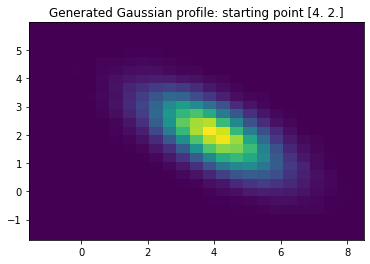

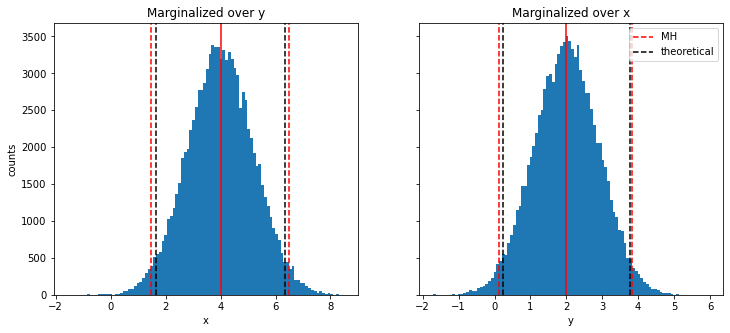

Mean X:     3.999959760255406 +- 2.548705879907478
Credibility interval X:    [ 1.4512538803479278 , 6.486393052932028 ]
Mean Y:     2.0001704537466494 +- 1.8703700773224905
Credibility interval Y:    [ 0.12980037642415887 , 3.827924275783893 ]


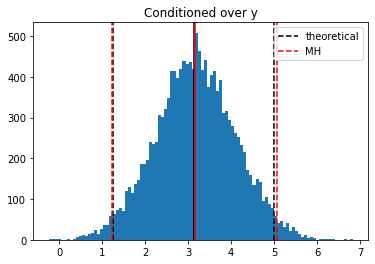

Credibility interval:    [ 1.2401966603596375 , 5.059437360217879 ]
Mean =  3.17 +- 1.89


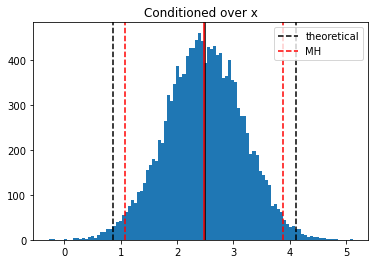

Credibility interval:    [ 1.0684528189291085 , 3.878151174527882 ]
Mean =  2.48 +- 1.40


In [45]:
fin1, trace1 = GS(mu)
plot_gauss(fin1, mu)

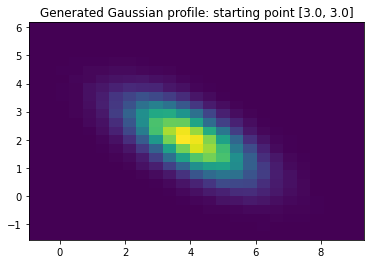

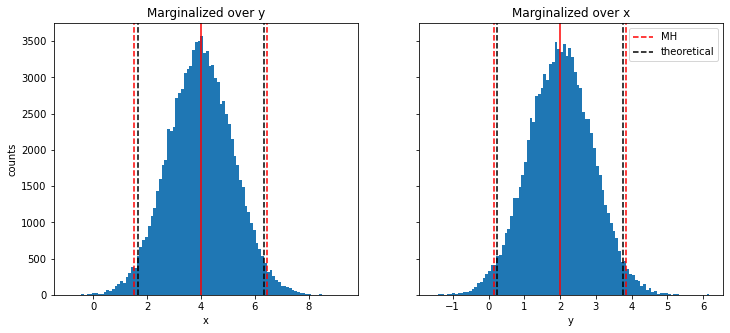

Mean X:     3.986150904211157 +- 2.4703662658042513
Credibility interval X:    [ 1.5157846384069056 , 6.441174580346268 ]
Mean Y:     2.0092917731920834 +- 1.8658669524680567
Credibility interval Y:    [ 0.14342482072402674 , 3.855174049189212 ]


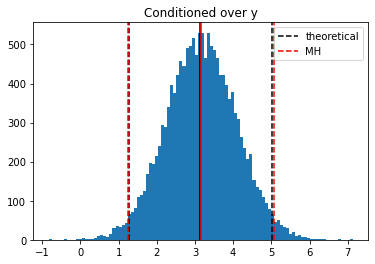

Credibility interval:    [ 1.2358212121584762 , 5.062619175404243 ]
Mean =  3.17 +- 1.89


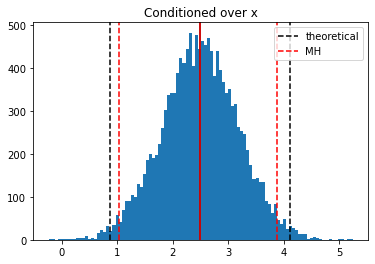

Credibility interval:    [ 1.019712661096203 , 3.8729605048501585 ]
Mean =  2.49 +- 1.38
#############################################################################


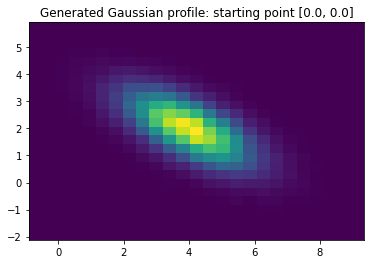

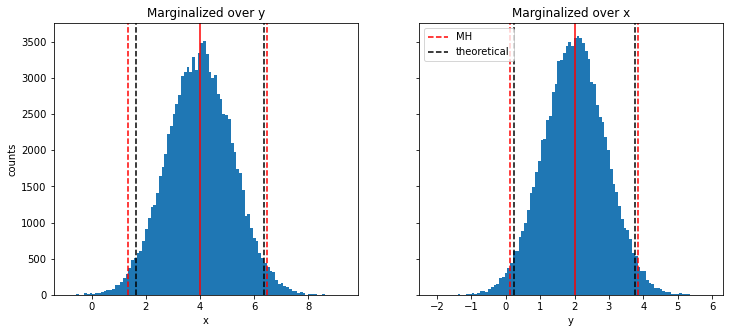

Mean X:     3.9965071619418113 +- 2.6397764108415602
Credibility interval X:    [ 1.356730751100251 , 6.471864751527241 ]
Mean Y:     2.002215180256075 +- 1.8685607879120223
Credibility interval Y:    [ 0.13365439234405274 , 3.83050441283617 ]


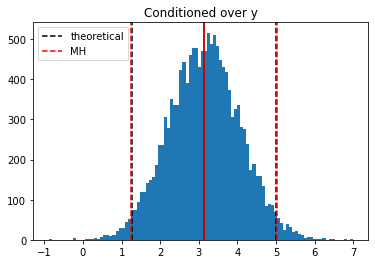

Credibility interval:    [ 1.2354674955209082 , 5.0210598592694105 ]
Mean =  3.15 +- 1.88


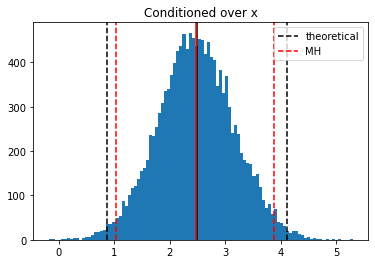

Credibility interval:    [ 1.022334864648347 , 3.8761051094212493 ]
Mean =  2.48 +- 1.40
#############################################################################


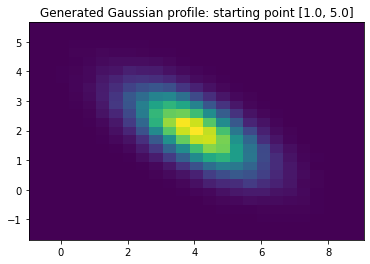

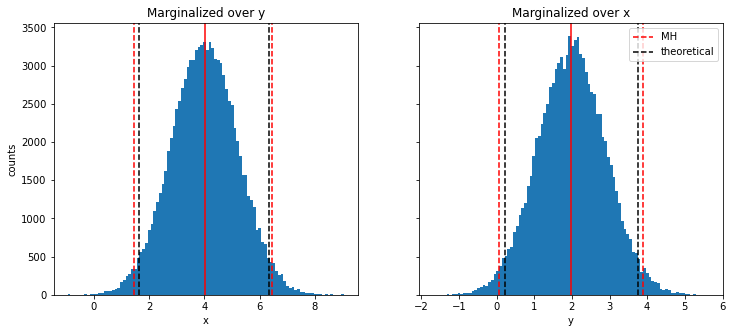

Mean X:     4.00758465120867 +- 2.5531773644015616
Credibility interval X:    [ 1.454407286807108 , 6.459002578622686 ]
Mean Y:     1.9907999746457279 +- 1.9200501441648494
Credibility interval Y:    [ 0.07074983048087846 , 3.8907802665962183 ]


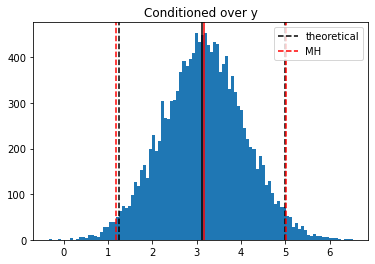

Credibility interval:    [ 1.1723608585554763 , 5.016707970285951 ]
Mean =  3.16 +- 1.86


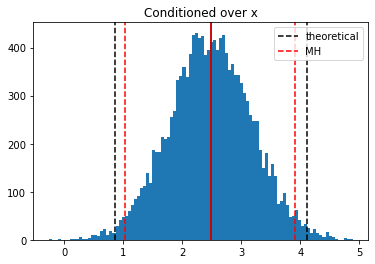

Credibility interval:    [ 1.0234384801533913 , 3.909703838944475 ]
Mean =  2.48 +- 1.43


In [46]:
r = [3.,3.]
fin2, trace2 = GS(r)
plot_gauss(fin2, r)
print("#############################################################################")

r = [0.,0.]
fin3, trace3 = GS(r)
plot_gauss(fin3, r)
print("#############################################################################")

r = [1.,5.]
fin4, trace4 = GS(r)
plot_gauss(fin4, r)

As in the previous case, we run convergence test and GR test.

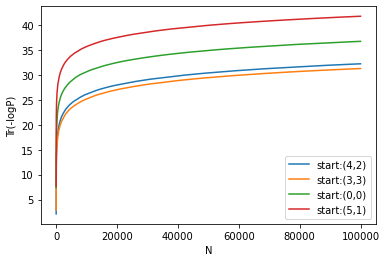

In [47]:
mvec = np.linspace(1,len(fin1),len(fin1))
plt.plot(mvec, trace1, label="start:(4,2)")
plt.plot(mvec, trace2, label="start:(3,3)")
plt.plot(mvec, trace3, label="start:(0,0)")
plt.plot(mvec, trace4, label="start:(5,1)")
plt.xlabel("N")
plt.ylabel("Tr(-logP)")
plt.legend()
plt.show()

In [48]:
burnin = int(0.2*len(fin1))
fin1 = fin1[burnin:]
fin2 = fin2[burnin:]
fin3 = fin3[burnin:]
fin4 = fin4[burnin:]

trace1_new=new_trace(fin1)
trace2_new=new_trace(fin2)
trace3_new=new_trace(fin3)
trace4_new=new_trace(fin4)


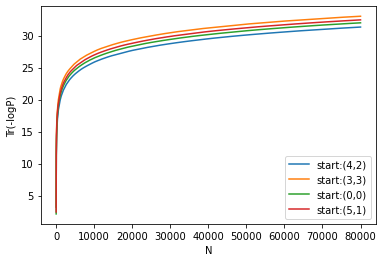

In [49]:
mvec = np.linspace(1,len(fin1),int(len(fin1)))
plt.plot(mvec, trace1_new, label="start:(4,2)")
plt.plot(mvec, trace2_new, label="start:(3,3)")
plt.plot(mvec, trace3_new, label="start:(0,0)")
plt.plot(mvec, trace4_new, label="start:(5,1)")
plt.xlabel("N")
plt.ylabel("Tr(-logP)")
plt.legend()
plt.show()

In [50]:
av1 = sum(fin1)/int(len(fin1))
av2 = sum(fin2)/int(len(fin2))
av3 = sum(fin3)/int(len(fin3))
av4 = sum(fin4)/int(len(fin4))
av_tot = sum

av_theta = np.array([av1,av2,av3,av4])   # array of the averages, each component is the mean of a chain
#print(av_theta)

av_tot = sum(av_theta)/4
print("Total average between chains:   ", av_tot)

#variance within a chain
def chain_var(vec,mean):
    s = 0.
    for i in range(int(len(vec))):
        s += np.outer(vec[i]-mean,vec[i]-mean)
    s /= (len(vec)-1)
    return s

#now we compute the average "variance within a chain"
var = np.array([chain_var(fin1,av1),chain_var(fin2,av2),chain_var(fin3,av3),chain_var(fin4,av4)])
av_var = sum(var)/4
print("Average <variance within a chain>:   ","\n",av_var)

# now B/N, or variance between chains
z = 0.
for j in range(4):
    z += np.outer(av_theta[j]-av_tot,av_theta[j]-av_tot)

z /= 3.
print("Variance between chains: ","\n",z)

final_var = (len(fin1)-1)/len(fin1)*av_var + z
print()
print("Estimated variance:  ","\n", final_var)

#Gelman Rubin test
R = final_var/av_var 
R_ratio = sum(sum(R))/4
print("R=",R_ratio)



Total average between chains:    [3.99405591 2.00308581]
Average <variance within a chain>:    
 [[ 1.43894325 -0.70157015]
 [-0.70157015  0.8092547 ]]
Variance between chains:  
 [[ 0.00016375 -0.00014313]
 [-0.00014313  0.00012631]]

Estimated variance:   
 [[ 1.43908902 -0.7017045 ]
 [-0.7017045   0.80937089]]
R= 1.0001569728862272
